# TP3

In [60]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 

### Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

In [61]:
image_template = cv2.imread('TP3/template/pattern.png', cv2.IMREAD_GRAYSCALE)
# w, h = image_template.shape[::-1]

image_1 =  cv2.imread('TP3/images/COCA-COLA-LOGO.jpg', cv2.IMREAD_GRAYSCALE)
print(image_1.shape)
image_2 =  cv2.imread('TP3/images/coca_logo_1.png', cv2.IMREAD_GRAYSCALE)
print(image_2.shape)
image_3 =  cv2.imread('TP3/images/coca_logo_2.png', cv2.IMREAD_GRAYSCALE)
print(image_3.shape)
image_4 =  cv2.imread('TP3/images/coca_multi.png', cv2.IMREAD_GRAYSCALE)
print(image_4.shape)
image_5 =  cv2.imread('TP3/images/coca_retro_1.png', cv2.IMREAD_GRAYSCALE)
print(image_5.shape)
image_6 =  cv2.imread('TP3/images/coca_retro_2.png', cv2.IMREAD_GRAYSCALE)
print(image_6.shape)
image_7 =  cv2.imread('TP3/images/logo_1.png', cv2.IMREAD_GRAYSCALE)
print(image_7.shape)


(1389, 1389)
(500, 207)
(363, 233)
(598, 799)
(493, 715)
(429, 715)
(450, 687)


In [62]:
def binarize_image(image):
    _, binary_image = cv2.threshold(image_template, 200, 255, cv2.THRESH_BINARY)
    return binary_image

In [ ]:
# Template preprocessing
image_template_binary = binarize_image(image_template)
print(image_template_binary.shape)

# plt.imshow(cv2.pyrUp(cv2.pyrUp(image_template_binary)), cmap='gray')
# print(image_template_binary.shape)
# image_template_binary = cv2.pyrUp(image_template_binary-255)
image_template_binary = image_template_binary
# plt.imshow(image_template_binary, cmap='gray')
edges = cv2.GaussianBlur(image_template_binary, (3, 3), 0)
edges = cv2.Canny(image_template_binary, 100, 200)
# edges = cv2.Laplacian(image_template_binary, cv2.CV_64F)

plt.imshow(cv2.resize(edges, None, fx=50, fy=50), cmap='gray')
image_template_binary = edges


(175, 400)


(500, 207)


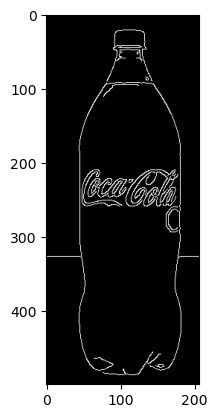

In [179]:
# Image preprocessing
# ret, image_1_binary = cv2.threshold(image_6, 200, 255, cv2.THRESH_BINARY)
image_1_binary=image_2
# image_1_binary = image_1_binary-255
plt.imshow(image_1_binary, cmap='gray')
print(image_1_binary.shape)
image_1_binary = cv2.GaussianBlur(image_1_binary,(5,5),0)
edges_1 = cv2.Canny(image_1_binary, 100, 300)

# edges_1 = cv2.Laplacian(image_1_binary, cv2.CV_64F)

plt.imshow(edges_1, cmap='gray')
image_1_binary = edges_1

(88, 200)
-0.03587993234395981 0.13839221000671387 (1, 241) (5, 193)
-0.03587993234395981 0.13839221000671387 (1, 241) (5, 193)
(157, 359)
0.22567473351955414


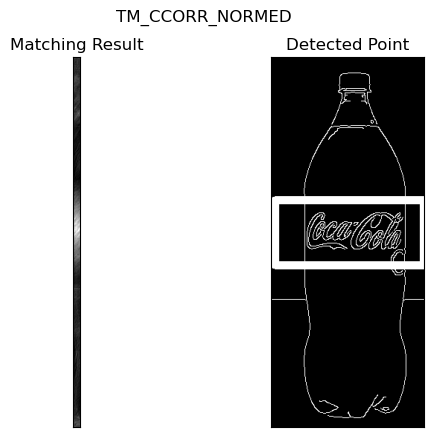

In [180]:
# All the 6 methods for comparison in a list
methods = ['TM_CCOEFF', 'TM_CCOEFF_NORMED', 'TM_CCORR',
            'TM_CCORR_NORMED', 'TM_SQDIFF', 'TM_SQDIFF_NORMED']
 
# scales = np.linspace(1, 20, 10) # image_1
scales = np.linspace(0.5, 20, 50) # image_3
max_value = 0
img_max = None
img_matching = None
for scale in scales:
    image_template_binary_resize = cv2.resize(image_template_binary, None, fx=scale, fy=scale)
    # image_template_binary_resize = image_template_binary
    print(image_template_binary_resize.shape)
    
    img = image_1_binary.copy()
    # img = cv2.resize(img, None, fx=scale, fy=scale)
    # method = getattr(cv2, meth)
 
    
    # Apply template Matching
    try:
        res = cv2.matchTemplate(img,image_template_binary_resize, cv2.TM_CCOEFF_NORMED)
    except Exception as e:
        break
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print(min_val, max_val, min_loc, max_loc)    
    
    try:
        res = cv2.matchTemplate(img,image_template_binary_resize, cv2.TM_CCORR_NORMED)
    except Exception as e:
        break
    min_val_1, max_val_1, min_loc_1, max_loc_1 = cv2.minMaxLoc(res)
    print(min_val, max_val, min_loc, max_loc)
    
    if max_val_1 > max_val:
        max_val = max_val_1
        max_loc = max_loc_1
    
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    # if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
    #     top_left = min_loc
    # else:
    top_left = max_loc
    w, h = image_template_binary_resize.shape[::-1]
    bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv2.rectangle(img,top_left, bottom_right, 255, 2)
    # 
    # plt.subplot(121),plt.imshow(res,cmap = 'gray')
    # plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(img,cmap = 'gray')
    # plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    # plt.suptitle('TM_CCORR_NORMED')
    # plt.show()
 
    if max_val > max_value:
        img_matching = res.copy()
        img_max = img.copy()
        top_left_max = max_loc
        w, h = image_template_binary_resize.shape[::-1]
        bottom_right_max = (top_left_max[0] + w, top_left_max[1] + h)
        max_value = max_val
 
cv2.rectangle(img_max,top_left_max, bottom_right_max, 255, 10)
print(max_value)
plt.subplot(121),plt.imshow(img_matching,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_max,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED')
plt.show()

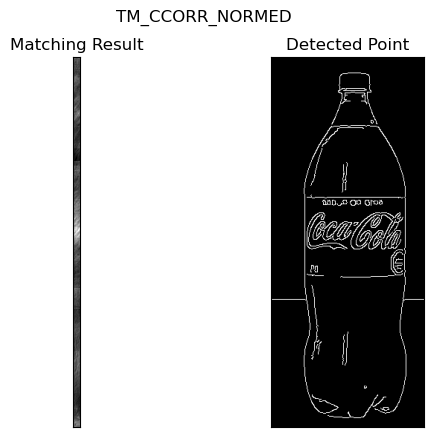

In [86]:
cv2.rectangle(img_max,top_left_max, bottom_right_max, 255, 2)
 
plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED')
plt.show()

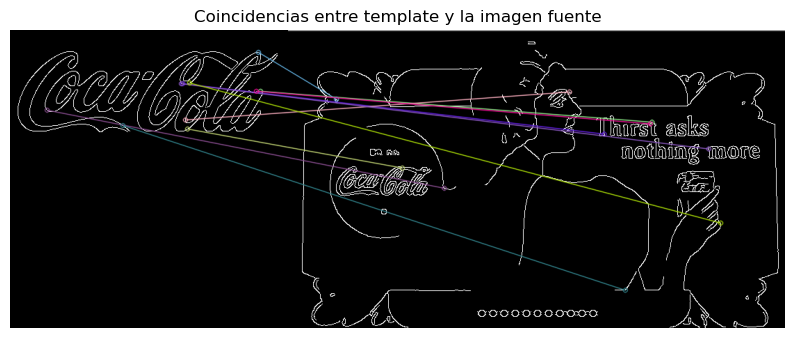

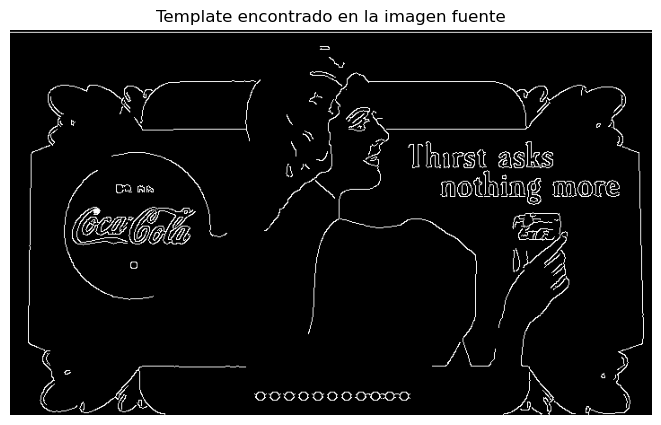

In [115]:
orb = cv2.ORB_create()
template = image_template_binary
image = image_1_binary


# Detectar puntos clave y descriptores en ambas imágenes
keypoints_image, descriptors_image = orb.detectAndCompute(image, None)
keypoints_template, descriptors_template = orb.detectAndCompute(template, None)

# Utilizar un matcher (Brute-Force) para emparejar los descriptores
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors_template, descriptors_image)

# Ordenar las coincidencias por distancia (las mejores coincidencias primero)
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar las mejores coincidencias
img_matches = cv2.drawMatches(template, keypoints_template, image, keypoints_image, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Mostrar las coincidencias
plt.figure(figsize=(10, 5))
plt.imshow(img_matches)
plt.title('Coincidencias entre template y la imagen fuente')
plt.axis('off')
plt.show()

# Obtener los puntos clave que coinciden
src_pts = np.float32([keypoints_template[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_image[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Calcular la transformación homográfica entre el template y la imagen fuente
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Usar la homografía para transformar las coordenadas del template sobre la imagen fuente
h, w = template.shape
pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, M)

# Dibujar el rectángulo alrededor de la región detectada en la imagen fuente
image_with_rectangle = cv2.polylines(image.copy(), [np.int32(dst)], True, (255, 0, 0), 3, cv2.LINE_AA)

# Mostrar la imagen con el template encontrado
plt.figure(figsize=(10, 5))
plt.imshow(image_with_rectangle, cmap='gray')
plt.title('Template encontrado en la imagen fuente')
plt.axis('off')
plt.show()

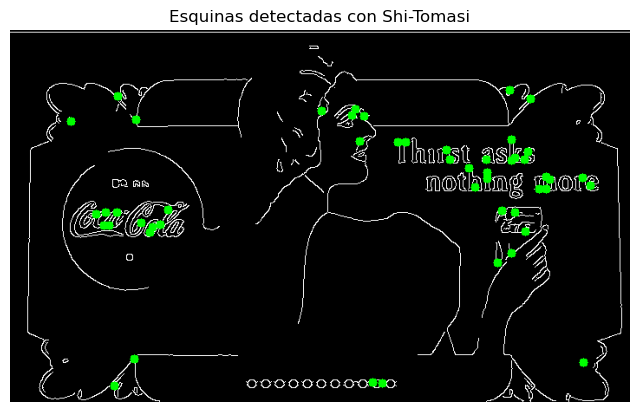

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen en escala de grises
img = image_1_binary.copy()

# Especificar el número máximo de esquinas a detectar
max_corners = 50

# Parámetros para Shi-Tomasi
quality_level = 0.02  # Umbral de calidad
min_distance = 5     # Distancia mínima entre esquinas detectadas

# Detectar las esquinas usando Shi-Tomasi
corners = cv2.goodFeaturesToTrack(img, max_corners, quality_level, min_distance)

# Convertir las esquinas a enteros (las devuelve en float32 por defecto)
corners = np.intp(corners)

# Dibujar las esquinas en la imagen original (convertida a color para poder dibujar)
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
for i in corners:
    x, y = i.ravel()
    cv2.circle(img_color, (x, y), 5, (0, 255, 0), -1)

# Mostrar la imagen con las esquinas detectadas
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.title("Esquinas detectadas con Shi-Tomasi")
plt.axis('off')
plt.show()


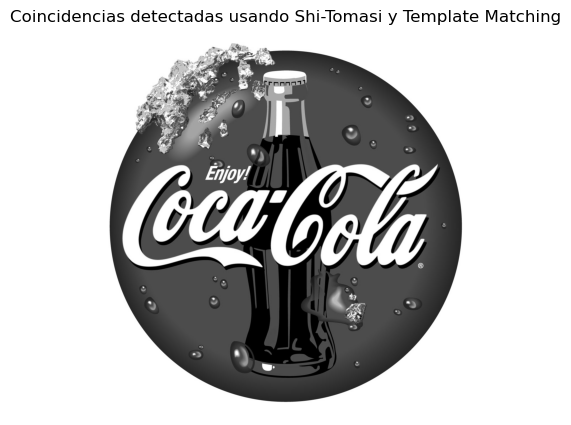

In [122]:
# Cargar la imagen de origen y la plantilla
image = image_1
template = image_template

# Dimensiones de la plantilla
w, h = template.shape[::-1]

# 1. Detectar esquinas en la imagen de origen con Shi-Tomasi
corners_image = cv2.goodFeaturesToTrack(image, maxCorners=100, qualityLevel=0.01, minDistance=10)
corners_image = np.intp(corners_image)

# 2. Detectar esquinas en la plantilla con Shi-Tomasi (para obtener áreas similares en la plantilla)
corners_template = cv2.goodFeaturesToTrack(template, maxCorners=10, qualityLevel=0.01, minDistance=5)
corners_template = np.intp(corners_template)

# 3. Crear una copia de la imagen de origen para dibujar las coincidencias
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Recorrer cada esquina detectada en la imagen de origen
for corner in corners_image:
    x, y = corner.ravel()
    
    # Definir una región de interés (ROI) alrededor de la esquina detectada
    roi = image[y-h//2:y+h//2, x-w//2:x+w//2]  # Se asegura de que sea del tamaño del template
    
    if roi.shape[0] == h and roi.shape[1] == w:  # Asegurarse de que la ROI sea válida

        # 4. Aplicar matchTemplate solo en esta ROI
        result = cv2.matchTemplate(roi, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # 5. Dibujar un rectángulo en la imagen de origen donde se encontró la coincidencia
        top_left = (x + max_loc[0] - w // 2, y + max_loc[1] - h // 2)
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(image_color, top_left, bottom_right, (0, 255, 0), 2)

# Mostrar la imagen con las coincidencias detectadas
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
plt.title('Coincidencias detectadas usando Shi-Tomasi y Template Matching')
plt.axis('off')
plt.show()

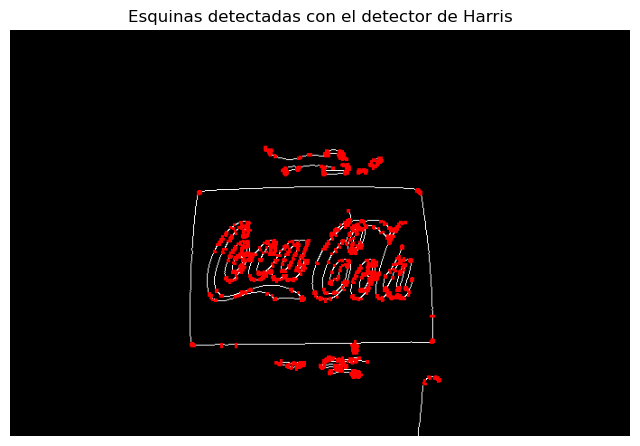

In [144]:
# Cargar la imagen en escala de grises
img = image_1_binary.copy()

# Convertir la imagen a float32 para que funcione con cornerHarris
img_float = np.float32(img)

# Aplicar el detector de esquinas Harris
block_size = 2      # Tamaño de la vecindad considerada para el cálculo del gradiente
ksize = 3           # Tamaño del filtro Sobel usado para calcular las derivadas
k = 0.04            # Parámetro de Harris
harris_response = cv2.cornerHarris(img_float, block_size, ksize, k)

# Dilatar el resultado para marcar mejor las esquinas
harris_response = cv2.dilate(harris_response, None)

# Umbral para considerar una esquina fuerte (puedes ajustar este valor)
threshold = 0.01 * harris_response.max()

# Crear una copia de la imagen original en color para dibujar las esquinas detectadas
img_harris = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Marcar en rojo las esquinas donde la respuesta de Harris sea mayor que el umbral
img_harris[harris_response > threshold] = [0, 0, 255]

# Mostrar la imagen con las esquinas detectadas
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
plt.title("Esquinas detectadas con el detector de Harris")
plt.axis('off')
plt.show()

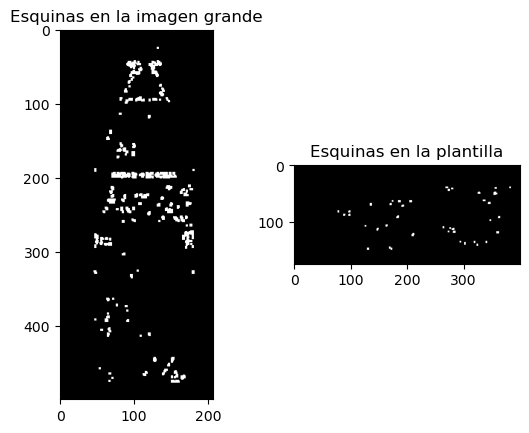

error: OpenCV(4.10.0) /home/conda/feedstock_root/build_artifacts/libopencv_1717728587725/work/modules/imgproc/src/templmatch.cpp:1175: error: (-215:Assertion failed) _img.size().height <= _templ.size().height && _img.size().width <= _templ.size().width in function 'matchTemplate'


In [147]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar las imágenes
img_large = image_2.copy()
img_template = image_template

# Convertir a escala de grises
gray_large = img_large # cv2.cvtColor(img_large, cv2.COLOR_BGR2GRAY)
gray_template = img_template # cv2.cvtColor(img_template, cv2.COLOR_BGR2GRAY)

# Detectar esquinas con Harris en la imagen grande
gray_large_float = np.float32(gray_large)
harris_corners_large = cv2.cornerHarris(gray_large_float, blockSize=2, ksize=3, k=0.04)

# Dilatar para visualizar mejor las esquinas
harris_corners_large = cv2.dilate(harris_corners_large, None)

# Umbral para considerar las esquinas fuertes
threshold = 0.01 * harris_corners_large.max()
corner_mask = harris_corners_large > threshold

# Detectar esquinas en la plantilla
gray_template_float = np.float32(gray_template)
harris_corners_template = cv2.cornerHarris(gray_template_float, blockSize=2, ksize=3, k=0.04)
harris_corners_template = cv2.dilate(harris_corners_template, None)
template_corner_mask = harris_corners_template > threshold

# Visualización de esquinas
plt.subplot(121), plt.imshow(corner_mask, cmap='gray')
plt.title('Esquinas en la imagen grande')
plt.subplot(122), plt.imshow(template_corner_mask, cmap='gray')
plt.title('Esquinas en la plantilla')
plt.show()

# Aplicar MatchTemplate solo en regiones con esquinas
result = cv2.matchTemplate(gray_large, gray_template, cv2.TM_CCOEFF_NORMED)

# Umbral para considerar una coincidencia válida
threshold = 0.8
loc = np.where(result >= threshold)

# Dibujar los rectángulos en las coincidencias
for pt in zip(*loc[::-1]):
    cv2.rectangle(img_large, pt, (pt[0] + img_template.shape[1], pt[1] + img_template.shape[0]), (0, 0, 255), 2)

# Mostrar el resultado final
plt.imshow(cv2.cvtColor(img_large, cv2.COLOR_BGR2RGB))
plt.title('Resultado de MatchTemplate con Harris')
plt.show()


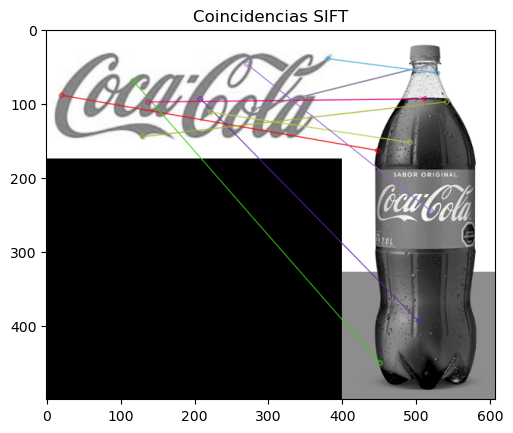

In [150]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar las imágenes
img_large = image_2.copy() 
img_template= image_template

# Crear objeto SIFT
sift = cv2.SIFT_create()

# Detectar puntos clave y descriptores
keypoints_large, descriptors_large = sift.detectAndCompute(img_large, None)
keypoints_template, descriptors_template = sift.detectAndCompute(img_template, None)

# Usar BFMatcher para emparejar los descriptores
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Realizar la coincidencia
matches = bf.match(descriptors_template, descriptors_large)

# Ordenar las coincidencias por distancia (las mejores coincidencias al principio)
matches = sorted(matches, key=lambda x: x.distance)

# Dibujar las mejores coincidencias
img_matches = cv2.drawMatches(img_template, keypoints_template, img_large, keypoints_large, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Mostrar las coincidencias
plt.imshow(img_matches)
plt.title('Coincidencias SIFT')
plt.show()


In [22]:
image_1_down = cv2.pyrDown(image_1)
image_1_2down = cv2.pyrDown(image_1_down)
image_1_up = cv2.pyrUp(image_1)
image_1_2up = cv2.pyrUp(image_1_up)
cv2.imshow('Logo detectado', image_1_up)
cv2.waitKey(0)
cv2.destroyAllWindows()